# Sussex Quantum

Solves the time-dependent Schrödinger equation, $i \hbar \frac{d}{dt}| \psi(t) \rangle = H(t) | \psi(t)\rangle$:

```python
sesolve(H, psi0, t_list, e_ops=None, args=None, options=None)
```

- `H`: Hamiltonian (static or time-dependent)
- `psi0`: Initial state vector
- `t_list`: Array of time points for solution
- `e_ops`: Operators to monitor (expectation values)
- `args`: Extra parameters for time-dependent Hamiltonians
- `options`: Solver settings (tolerance, steps, etc.)

The `result` object
- `result.states`: List of quantum states at each time point (if stored)
- `result.expect`: Expecation values for each operator in `e_ops`
- `result.times`: Time points (same as input `t_list`)


### Questions
- Why do we divide the spin operators by 2?
- Explain carefully every single line.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import qutip

# Set high precision for numerical stability
qutip.settings.atol = 1e-12 # x_{i+1} - x_i < atol
qutip.settings.rtol = 1e-10 # (x_{i+1} - x_i) / x_i < rtol

# Define fundamental constants
hbar = 1.0

In [2]:
def setup_spin_system(omega_eZ, omega_1MW, omega_MW, detuning=0):
    """
    Setup the spin-1/2 system with ESR driving in laboratory frame

    Parameters:
    -----------
    omega_eZ : float
        Electron Zeeman frequency [rad/ns]
    omega_1MW : float
        Rabi frequency of the 1 MW microwave field [rad/ns]
    omega_MW : float
        Frequency of the microwave field [rad/ns]
    detuning : float
        Detuning of the microwave field from resonance [rad/ns]

    Returns:
    --------
    H0 : Qobj
        Static Hamiltonian of the system
    H1 : Qobj
        Driving Hamiltonian of the system
    args : dict
        Dictionary of parameters for time-dependent Hamiltonian
    """

    # Define spin operators for s=1/2
    sx = sigmax() / 2
    sy = sigmay() / 2
    sz = sigmaz() / 2

    # Static Hamiltonian (Zeeman term)
    H0 = omega_eZ * sz

    # Time-dependent ESR Hamiltonian
    # H_ESR(t) = ω₁[cos(ω_MW t)sx - sin(ω_MW t)sy]
    # We'll express this as two time-dependent terms
    
    # Define the time-dependent coefficients
    def H1_coeff_t(t, args):
        return args['omega_1MW'] * np.cos(args['omega_MW'] * t)
    
    def H2_coeff_t(t, args):
        return -args['omega_1MW'] * np.sin(args['omega_MW'] * t)
    
    # Time-dependent Hamiltonian components
    H1_terms = [
        [sx, H1_coeff_t],
        [sy, H2_coeff_t]
    ]

    # Arguments for time-dependent functions
    args = {
        'omega_1MW': omega_1MW,
        'omega_MW': omega_MW + detuning  # Apply detuning
    }
    
    H_total = [H0] + H1_terms

    return H_total, args, (sx, sy, sz)


def analytical_rabi_solution(omega_1MW, delta, times):
    """
    Analytical solution for Rabi oscillations
    
    Parameters:
    -----------
    omega_1MW : float
        Rabi frequency
    delta : float  
        Detuning Δ = omega_MW - omega_eZ
    times : array
        Time points
        
    Returns:
    --------
    P_up : array
        Probability of spin up
    P_down : array
        Probability of spin down  
    """
    
    # Effective Rabi frequency
    Omega_eff = np.sqrt(omega_1MW**2 + delta**2)
    
    # Population of spin down state
    P_down = (omega_1MW / Omega_eff)**2 * np.sin(Omega_eff * times / 2)**2
    
    # Population of spin up state  
    P_up = 1 - P_down
    
    return P_up, P_down

def compare_analytical_numerical(result, times, omega_1MW, delta):
    """
    Compare numerical results with analytical solution
    """
    
    # Numerical probabilities
    P_up_numerical = []
    for state in result.states:
        # Probability in |↑⟩ state
        prob_up = abs(state[0,0])**2  
        P_up_numerical.append(prob_up)
    
    # Analytical solution
    P_up_analytical, P_down_analytical = analytical_rabi_solution(
        omega_1MW, delta, times)
    
    return np.array(P_up_numerical), P_up_analytical


def simulate_rabi_oscillations(omega_eZ, omega_1MW, omega_MW, T_max, n_points, detuning=0, convergence_test=True):
    """
    Simulate Rabi oscillations of a spin-1/2 system under ESR driving

    Parameters:
    -----------
    omega_eZ : float
        Electron Zeeman frequency [rad/ns]
    omega_1MW : float
        Rabi frequency of the 1 MW microwave field [rad/ns]
    omega_MW : float
        Frequency of the microwave field [rad/ns]
    T_max : float
        Maximum time for simulation [ns]
    n_steps : int
        Number of time steps in the simulation
    detuning : float
        Detuning of the microwave field from resonance [rad/ns]
    convergence_test : bool
        Whether to perform a convergence test

    Returns:
    --------
    result : Result
        QuTiP simulation result
    times : array
        Time points
    expectation_values : dict
        Expectation values of spin operators
    """

    # Setup the system
    H_total, args, (sx, sy, sz) = setup_spin_system(omega_eZ, omega_1MW, omega_MW, detuning)

    # Initial state: spin up along z-axis
    psi0 = basis(2, 0)  # |0> state, |↑⟩ state

    # Time array with proper sampling
    # Critical: sampling rate > 2*omega_max (Nyquist criterion)
    omega_max = max(omega_eZ, omega_MW, omega_1MW)
    min_period = 2 * np.pi / omega_max
    
    # Ensure sufficient time resolution
    dt = T_max / n_points
    if dt > min_period / 10:
        print(f"Warning: Time step {dt:.2e} ns may be too large.")
        print(f"Recommended: dt < {min_period/10:.2e} ns")
    
    times = np.linspace(0, T_max, n_points)
    
    # Operators to monitor
    e_ops = [sx, sy, sz, sigmap(), sigmam()]
    
    # Solve Schrödinger equation
    result = sesolve(H_total, psi0, times, e_ops=e_ops, args=args, options=Options(store_states=True))
    
    # Convergence and norm test
    if convergence_test:
        norm_deviations = []
        for i, t in enumerate(times):
            state = result.states[i]
            norm = state.norm()
            norm_deviations.append(abs(norm - 1.0))
        
        max_norm_error = max(norm_deviations)
        print(f"Maximum norm deviation: {max_norm_error:.2e}")
        
        if max_norm_error > 1e-8:
            print("Warning: Significant norm deviation detected!")
    
    # Extract expectation values
    expectation_values = {
        'sx': result.expect[0],
        'sy': result.expect[1], 
        'sz': result.expect[2],
        'sp': result.expect[3],  # σ⁺ expectation
        'sm': result.expect[4]   # σ⁻ expectation
    }

    return result, times, expectation_values, (sx, sy, sz)

Simulation Parameters:
ω_eZ/2π = 10.0 GHz
ω_1MW/2π = 0.100 GHz
ω_MW/2π = 10.0 GHz
T_max = 100.0 ns
Time step = 0.020 ns
Recommended: dt < 1.00e-02 ns
Maximum norm deviation: 3.33e-16


c:\git\sq\.venv\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


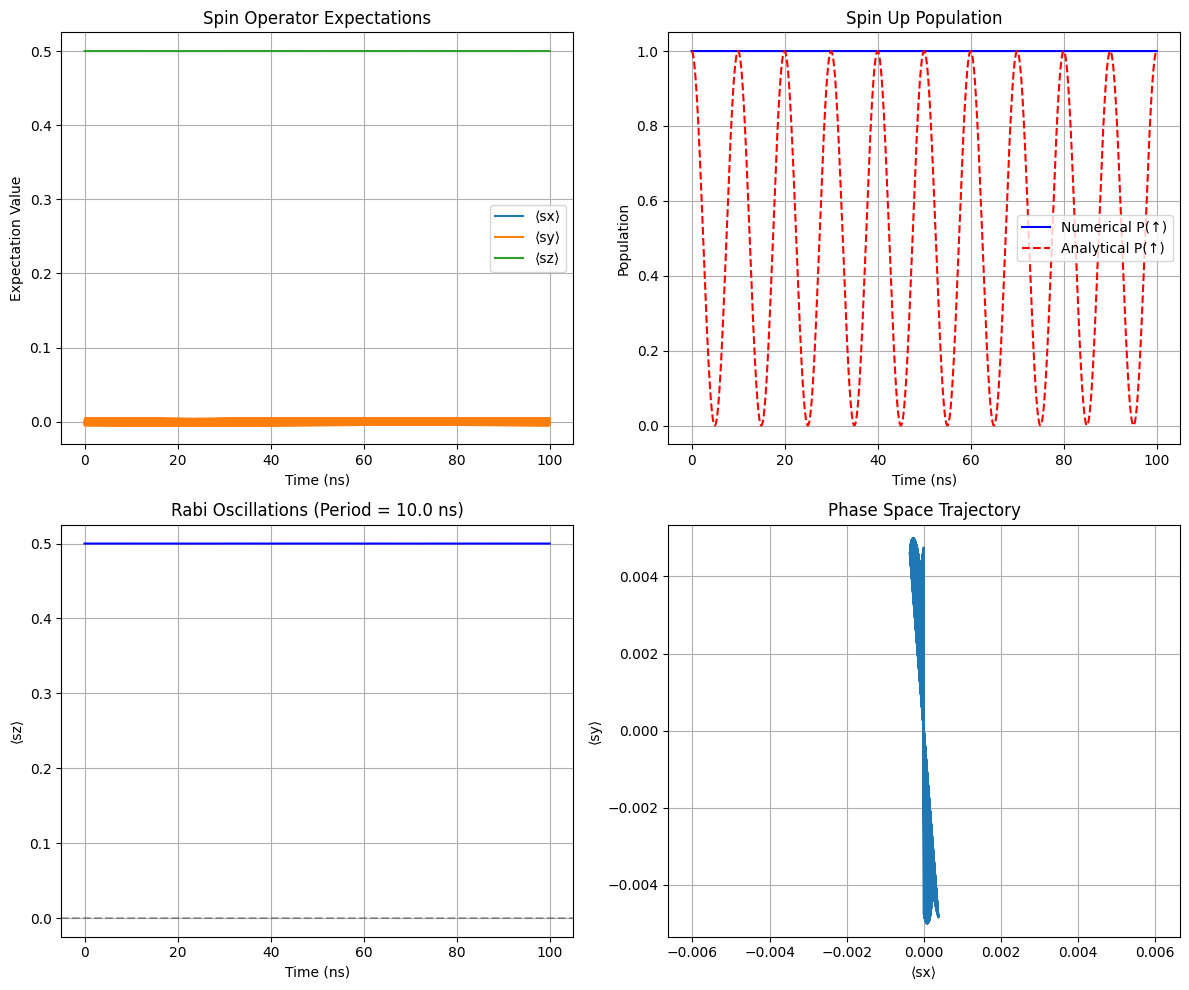

(<Result
   Solver: sesolve
   Solver stats:
     method: 'scipy zvode adams'
     init time: 0.0
     preparation time: 0.0
     run time: 0.39951539039611816
     solver: 'Schrodinger Evolution'
   Time interval: [0.0, 100.0] (5000 steps)
   Number of e_ops: 5
   States saved.
 >,
 array([0.00000000e+00, 2.00040008e-02, 4.00080016e-02, ...,
        9.99599920e+01, 9.99799960e+01, 1.00000000e+02], shape=(5000,)),
 {'sx': array([ 0.00000000e+00,  4.40566367e-08,  7.53753761e-08, ...,
         -2.54548672e-04, -3.62448083e-04,  3.08168708e-05], shape=(5000,)),
  'sy': array([ 0.        , -0.00475558, -0.00293669, ...,  0.00323522,
          0.00460551, -0.00039117], shape=(5000,)),
  'sz': array([0.5       , 0.49997738, 0.49999138, ..., 0.49998947, 0.49997866,
         0.49999985], shape=(5000,)),
  'sp': array([ 0.00000000e+00+0.j        ,  4.40566367e-08-0.00475558j,
          7.53753761e-08-0.00293669j, ..., -2.54548672e-04+0.00323522j,
         -3.62448083e-04+0.00460551j,  3.081687

In [ ]:
"""
Complete simulation of Rabi oscillations with analysis
"""

# Physical parameters (in rad/ns)
omega_eZ = 2 * np.pi * 1.0  # 10 GHz Zeeman splitting
omega_1MW = 2 * np.pi * 0.1  # 100 MHz Rabi frequency  
omega_MW = omega_eZ          # On resonance

# Simulation parameters
T_max = 100.0  # 100 ns simulation time
n_points = 5000

print("Simulation Parameters:")
print(f"ω_eZ/2π = {omega_eZ/(2*np.pi):.1f} GHz")
print(f"ω_1MW/2π = {omega_1MW/(2*np.pi):.3f} GHz") 
print(f"ω_MW/2π = {omega_MW/(2*np.pi):.1f} GHz")
print(f"T_max = {T_max} ns")
print(f"Time step = {T_max/n_points:.3f} ns")

# Run simulation
result, times, expect, (sx, sy, sz) = simulate_rabi_oscillations(
    omega_eZ, omega_1MW, omega_MW, T_max, n_points)

# Compare with analytical solution
P_up_num, P_up_anal = compare_analytical_numerical(
    result, times, omega_1MW, delta=0)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Spin expectations
axes[0,0].plot(times, expect['sx'], label='⟨sx⟩')
axes[0,0].plot(times, expect['sy'], label='⟨sy⟩') 
axes[0,0].plot(times, expect['sz'], label='⟨sz⟩')
axes[0,0].set_xlabel('Time (ns)')
axes[0,0].set_ylabel('Expectation Value')
axes[0,0].set_title('Spin Operator Expectations')
axes[0,0].legend()
axes[0,0].grid(True)

# Population dynamics
axes[0,1].plot(times, P_up_num, 'b-', label='Numerical P(↑)')
axes[0,1].plot(times, P_up_anal, 'r--', label='Analytical P(↑)')
axes[0,1].set_xlabel('Time (ns)')
axes[0,1].set_ylabel('Population')
axes[0,1].set_title('Spin Up Population')
axes[0,1].legend()
axes[0,1].grid(True)

# Rabi oscillations in rotating frame
# Extract the envelope of Rabi oscillations
rabi_period = 2 * np.pi / omega_1MW
axes[1,0].plot(times, expect['sz'], 'b-')
axes[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1,0].set_xlabel('Time (ns)')
axes[1,0].set_ylabel('⟨sz⟩')
axes[1,0].set_title(f'Rabi Oscillations (Period = {rabi_period:.1f} ns)')
axes[1,0].grid(True)

# Phase space trajectory
axes[1,1].plot(expect['sx'], expect['sy'])
axes[1,1].set_xlabel('⟨sx⟩')
axes[1,1].set_ylabel('⟨sy⟩')
axes[1,1].set_title('Phase Space Trajectory')
axes[1,1].grid(True)
axes[1,1].axis('equal')

plt.tight_layout()
plt.show()

result, times, expect